# Variational AutoEncoder 연습

<img src="./img/vae.png" width="200%">

## 필요한 모듈 import
* tensorflow (신경망 구성, 변수 설정, 역전파, gradient descent etc)
* numpy (텐서 연산)
* matplotlib (결과 그래프 출력)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## MNIST 데이터세트 로딩

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


## 하이퍼 파라메터 설정
* hyer parameter는 사용자가 정의하는 변수들 
* learnable parameter는 학습을 통해 업데이트되는 변수들

In [3]:
# Parameters
learning_rate = 0.001
num_steps = 20000
batch_size = 64

## 러너블 파라메터 설정 (learnable parameter = network parameter)
                           
* 784 (input) $\rightarrow$ 512 (hidden) $\rightarrow$ 2(mean) + 2(std) $\rightarrow$ 2 (latent)  $\rightarrow$ 512 (hidden) $\rightarrow$ 784 (output)
   

In [4]:
# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 2

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# tf Graph input (28x28 = 784 image size)
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])

# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}

biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}


Instructions for updating:
Colocations handled automatically by placer.


## Encoder 부분 구축

<img src="./img/vae_encoder.png" width="50%">

In [10]:
# Building the encoder
def encoder(x):

    # encoder hidden layer 512
    en_hidden = tf.matmul(x, weights['encoder_h1']) + biases['encoder_b1']
    en_hidden = tf.nn.tanh(en_hidden)

    # latent layer 2
    z_mean = tf.matmul(en_hidden, weights['z_mean']) + biases['z_mean']
    z_std = tf.matmul(en_hidden, weights['z_std']) + biases['z_std']

    # Sampler: Normal (gaussian) random distribution
    eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
    z = z_mean + tf.exp(z_std / 2) * eps

    return z_mean, z_std, z


## Decoder 부분 구축

<img src="./img/vae_decoder.png" width="50%">

In [6]:
# Building the decoder (with scope to re-use these layers later)
def decoder(z):

    # decoder hidden layer 512
    de_hidden = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
    de_hidden = tf.nn.tanh(de_hidden)
    reconstruct = tf.matmul(de_hidden, weights['decoder_out']) + biases['decoder_out']
    reconstruct = tf.nn.sigmoid(reconstruct)
    
    return reconstruct


## Reconstruction Loss
<img src="./img/vae_rec_loss.png" width="400">

## KL Divergence (Regularization) Loss
<img src="./img/vae_kld_loss.png" width="450">

In [7]:
# Define VAE Loss
    
# latent computation
mean, std, latent = encoder(input_image)

# Reconstruct image from latent
reconstruct = decoder(latent)
    
# Reconstruction loss (binary cross entropy)
reconstruct_loss = input_image * tf.log(1e-10 + reconstruct) \
                   + (1 - input_image) * tf.log(1e-10 + 1 - reconstruct)
reconstruct_loss = -tf.reduce_sum(reconstruct_loss, 1)
    
# KL Divergence (regularization)loss
kl_div_loss = 1 + std - tf.square(mean) - tf.exp(std)
kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)

total_loss = tf.reduce_mean(reconstruct_loss + kl_div_loss)

optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(total_loss)


Instructions for updating:
Use tf.cast instead.


In [8]:
# Start training
sess = tf.Session()

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Run the initializer
sess.run(init)

for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)

    # Train
    feed_dict = {input_image: batch_x}
    _, l = sess.run([train_op, total_loss], feed_dict=feed_dict)
    
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))


Step 1, Loss: 662.471252
Step 1000, Loss: 175.952881
Step 2000, Loss: 162.391403
Step 3000, Loss: 159.222931
Step 4000, Loss: 157.175812
Step 5000, Loss: 163.889954
Step 6000, Loss: 166.427582
Step 7000, Loss: 163.519989
Step 8000, Loss: 154.889740
Step 9000, Loss: 161.027374
Step 10000, Loss: 155.542450
Step 11000, Loss: 154.718674
Step 12000, Loss: 144.844543
Step 13000, Loss: 156.736450
Step 14000, Loss: 153.166199
Step 15000, Loss: 149.273468
Step 16000, Loss: 149.530792
Step 17000, Loss: 151.747818
Step 18000, Loss: 161.938873
Step 19000, Loss: 150.003616
Step 20000, Loss: 154.348236


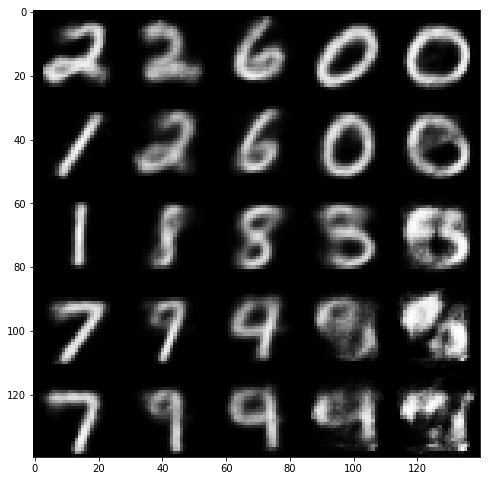

In [9]:
# Testing
# Generator takes noise as input
noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])

# Rebuild the decoder to create image from noise
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)


# Building a manifold of generated digits
n = 5
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28 * n, 28 * n))
for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        recon = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = recon[0].reshape(28, 28)

plt.figure(figsize=(8, 10))
Xi, Yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()